In [1]:
!git clone https://github.com/Bruce-A-R/High_Energy_Detector_Lab.git

# Go into the inner folder that actually contains spectrum_reader.py
%cd /content/High_Energy_Detector_Lab/High_Energy_Detector_Lab

!ls

Cloning into 'High_Energy_Detector_Lab'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 519 (delta 111), reused 23 (delta 23), pack-reused 336 (from 2)
Receiving objects: 100% (519/519), 7.88 MiB | 22.59 MiB/s, done.
Resolving deltas: 100% (271/271), done.
[Errno 2] No such file or directory: '/content/High_Energy_Detector_Lab/High_Energy_Detector_Lab'
/content
High_Energy_Detector_Lab  sample_data


In [14]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append('/content/High_Energy_Detector_Lab')
import spectrum_reader as sr

bgo_data_path = "High_Energy_Detector_Lab/BGO_detector/Am_angled"
bgo_bg_path   = "High_Energy_Detector_Lab/BGO_detector/unangled/bgBGO.Spe"

print("Angled BGO files:")
print(os.listdir(bgo_data_path))

Angled BGO files:
['Am_BGO_90.Spe', 'Am_BGO_45.Spe', 'Am_BGO_165.Spe', 'AM_BGO_0.Spe', 'Am_BGO_135.Spe']


In [29]:
angles = []
amps   = []
amp_errs = []

am_range_bgo = range(0, 60)

for fname in sorted(os.listdir(bgo_data_path)):
    if not fname.lower().endswith(".spe"):
        continue
    if "am" not in fname.lower():
        continue

    m = re.search(r'_(\d+)\.spe$', fname, re.IGNORECASE)
    if not m:
        print("Could not find angle in", fname)
        continue

    angle = int(m.group(1))
    full_path = os.path.join(bgo_data_path, fname)

    try:
        mu, sig, amp = sr.subtract_and_fit(full_path, bgo_bg_path, am_range_bgo)
    except Exception as e:
        print(f"Fit failed for {fname} at angle {angle}: {e}")
        continue

    angles.append(angle)
    amps.append(amp)
    amp_errs.append(abs(sig*5))   # <-- error bar from Gaussian width


In [30]:
bgo_df = pd.DataFrame({
    "angle": angles,
    "amp": amps,
    "amp_err": amp_errs
}).sort_values("angle").reset_index(drop=True)

bgo_df

,angle,amp,amp_err
0,0,1437.585256,24.531690
1,45,1715.847477,23.072714
2,90,2113.527598,23.287178
3,135,1805.244927,23.717253
4,165,1473.465128,23.940004


In [32]:
# Save to the *outer* repo folder, where /content/High_Energy_Detector_Lab/angular_effects.py will live
bgo_df.to_csv("/content/High_Energy_Detector_Lab/BGO_angular_results.csv", index=False)


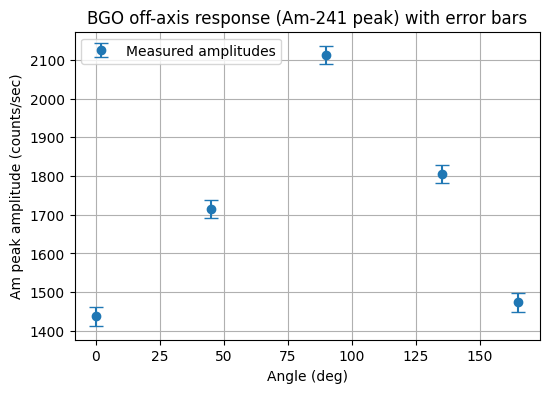

In [31]:
plt.figure(figsize=(6,4))
plt.errorbar(
    bgo_df["angle"],
    bgo_df["amp"],
    yerr=bgo_df["amp_err"],
    fmt='o',
    capsize=5,
    label="Measured amplitudes"
)

plt.xlabel("Angle (deg)")
plt.ylabel("Am peak amplitude (counts/sec)")
plt.title("BGO off-axis response (Am-241 peak) with error bars")
plt.grid(True)
plt.legend()
plt.show()


In [33]:
%cd /content/High_Energy_Detector_Lab
!ls

/content/High_Energy_Detector_Lab
 angular_effects.py	   efficiencies.py	  resolution.py
 BGO_angular_results.csv  'MAESTRO Screenshots'   spectrum_reader.py
 BGO_detector		   NaITi_detector	  workbooks_and_testing
 CdTe_detector		   __pycache__
 current_csv_results	   README.md


In [34]:
%%writefile angular_effects.py
"""
angular_effects.py

Use results produced with spectrum_reader (angle, amplitude, error)
to plot the angular response of a detector.
"""

import argparse
import pandas as pd
import matplotlib.pyplot as plt


def plot_amplitudes(table, detector):
    """Plot amplitude vs angle, with optional error bars."""

    plt.close("all")
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.set_title(f"{detector} off-axis response (Am-241 peak)")
    ax.set_xlabel("Angle (deg)")
    ax.set_ylabel("Peak amplitude (counts/sec)")

    if "amp_err" in table.columns:
        ax.errorbar(
            table["angle"],
            table["amp"],
            yerr=table["amp_err"],
            fmt="o",
            capsize=5,
            label="Measured amplitudes",
        )
    else:
        ax.scatter(table["angle"], table["amp"], label="Measured amplitudes")

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


def main(csv_path, detector):
    table = pd.read_csv(csv_path)
    plot_amplitudes(table, detector)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Plot angular response using spectrum_reader results."
    )
    parser.add_argument("csv", type=str, help="Path to angle–amplitude CSV")
    parser.add_argument("detector", type=str, help="Detector name")
    args = parser.parse_args()

    main(args.csv, args.detector)

Overwriting angular_effects.py


In [35]:
!python /content/High_Energy_Detector_Lab/angular_effects.py \
    "/content/High_Energy_Detector_Lab/BGO_angular_results.csv" \
    "BGO"


Figure(600x400)


In [37]:
bgo_df.to_csv("/content/High_Energy_Detector_Lab/BGO_angular_results.csv", index=False)
!ls /content/High_Energy_Detector_Lab


 angular_effects.py	   efficiencies.py	  resolution.py
 BGO_angular_results.csv  'MAESTRO Screenshots'   spectrum_reader.py
 BGO_detector		   NaITi_detector	  workbooks_and_testing
 CdTe_detector		   __pycache__
 current_csv_results	   README.md


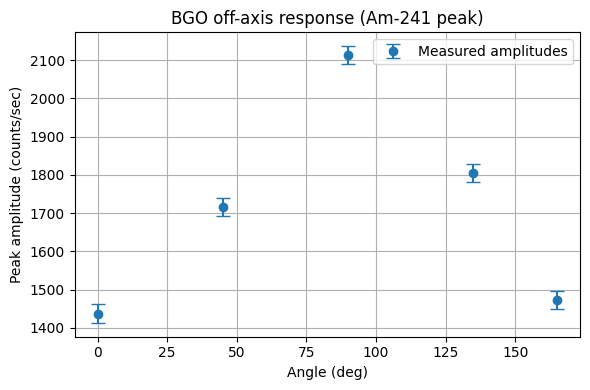

In [39]:
%matplotlib inline

import sys
sys.path.append("/content/High_Energy_Detector_Lab")

import angular_effects

csv_path = "/content/High_Energy_Detector_Lab/BGO_angular_results.csv"
detector = "BGO"

angular_effects.main(csv_path, detector)
